In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
import hvplot.xarray
import cartopy.crs as crs

In [3]:
# So far unable to get html reprs working with tqdm.notebook. So switch bach to old xr display
xr.set_options(display_style='text')

In [4]:
from src.dataloader import *

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir='/datadrive/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir='/datadrive/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn='/datadrive/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    val_days=7,
    split='train'
)

In [6]:
ds_valid = TiggeMRMSDataset(
    tigge_dir='/datadrive/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir='/datadrive/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn='/datadrive/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    val_days=7,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs
)

In [7]:
len(ds_train), len(ds_valid)

(11052, 3096)

In [9]:
len(ds_train.tigge.variable)

1

In [ ]:
ds_train.comp

In [56]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [57]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

In [58]:
X, y = next(iter(dl_train))

In [59]:
X.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 1, 128, 128]))

In [60]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [61]:
device

device(type='cuda')

In [62]:
import torch
import torch.nn as nn

In [63]:
class UpscalingCNN(nn.Module):
    def __init__(self, input_vars=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_vars, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        out = self.conv5(x)
        return out

In [83]:
model = UpscalingCNN().to(device)

In [84]:
criterion = nn.MSELoss()

In [85]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [86]:
import tqdm.notebook as tqdm

In [87]:
class Trainer():
    def __init__(self, model, optimizer, criterion, dl_train, dl_valid=None, 
                 valid_every_epochs=1):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        self.valid_every_epochs = valid_every_epochs
        
        self.epoch = 0
        self.train_losses = []
        self.train_epochs = []
        self.valid_losses = []
        self.valid_epochs = []
        
    def fit(self, epochs):

        # Epoch loop
        for epoch in range(1, epochs+1):

            prog_bar = tqdm.tqdm(total=len(dl_train), desc=f'Epoch {epoch}')
            train_loss, valid_loss = 0, 0

            # Train
            for i, (X, y) in enumerate(dl_train):
                X = X.to(device); y = y.to(device)
                y_hat = self.model(X)
                loss = self.criterion(y_hat, y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                prog_bar.update()
                train_loss += (loss.cpu().detach().numpy() - train_loss) / (i+1)
                prog_bar.set_postfix({'train_loss': train_loss})
            self.train_losses.append(train_loss)
            self.train_epochs.append(self.epoch)

            if (self.epoch-1) % self.valid_every_epochs == 0:
                # Valid
                for i, (X, y) in enumerate(dl_valid):
                    X = X.to(device); y = y.to(device)
                    y_hat = self.model(X)
                    loss = self.criterion(y_hat, y)

                    valid_loss += (loss.cpu().detach().numpy() - valid_loss) / (i+1)
                self.valid_losses.append(valid_loss)
                self.valid_epochs.append(self.epoch)

                prog_bar.set_postfix({'train_loss': train_loss, 'valid_loss': valid_loss}) 
                prog_bar.close()
        
            self.epoch += 1
        
    def plot_losses(self, plot_valid=True):
        plt.plot(self.train_epochs, self.train_losses, label='Train')
        if plot_valid: plt.plot(self.valid_epochs, self.valid_losses, label='Valid')
        plt.legend()
        

In [88]:
trainer = Trainer(model, optimizer, criterion, dl_train, dl_valid)

In [89]:
trainer.fit(epochs=5)

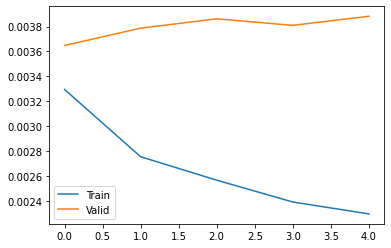

In [90]:
trainer.plot_losses()

In [91]:
X, y = next(iter(dl_valid))

In [92]:
y_hat = model(X.to(device)).cpu()

In [93]:
i=2

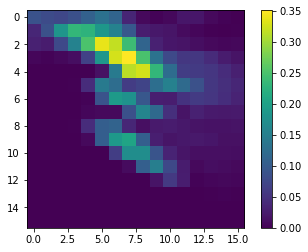

In [94]:
plt.imshow(X.numpy()[i, 0])
plt.colorbar();

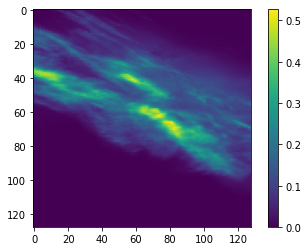

In [95]:
plt.imshow(y.numpy()[i, 0])
plt.colorbar();

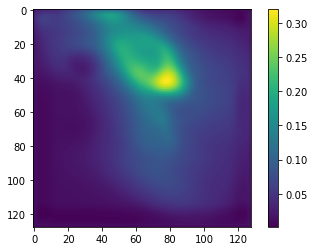

In [96]:
plt.imshow(y_hat.detach().numpy()[i, 0])
plt.colorbar();

## Full valid fields as xr

In [97]:
X, y = ds_valid.return_full_array(0)

In [112]:
pred = model(torch.FloatTensor(X[None]).to(device)).to('cpu').detach().numpy()[0, 0]

In [107]:
pred.shape

(744, 1376)

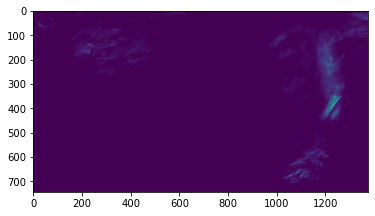

In [109]:
plt.imshow(y[0])

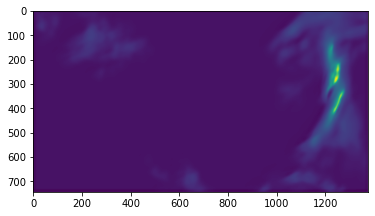

In [108]:
plt.imshow(pred)

In [111]:
ds_valid.tigge.valid_time

<xarray.DataArray 'valid_time' (valid_time: 70)>
array(['2020-05-01T00:00:00.000000000', '2020-05-01T12:00:00.000000000',
       '2020-05-02T00:00:00.000000000', '2020-05-02T12:00:00.000000000',
       '2020-05-03T00:00:00.000000000', '2020-05-03T12:00:00.000000000',
       '2020-05-04T00:00:00.000000000', '2020-05-04T12:00:00.000000000',
       '2020-05-05T00:00:00.000000000', '2020-05-05T12:00:00.000000000',
       '2020-05-06T00:00:00.000000000', '2020-05-06T12:00:00.000000000',
       '2020-05-07T00:00:00.000000000', '2020-05-07T12:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-06-01T12:00:00.000000000',
       '2020-06-02T00:00:00.000000000', '2020-06-02T12:00:00.000000000',
       '2020-06-03T00:00:00.000000000', '2020-06-03T12:00:00.000000000',
       '2020-06-04T00:00:00.000000000', '2020-06-04T12:00:00.000000000',
       '2020-06-05T00:00:00.000000000', '2020-06-05T12:00:00.000000000',
       '2020-06-06T00:00:00.000000000', '2020-06-06T12:00:00.000000000',
       '2020-06-07T00:00:00.000000000', '2020-06-07T12:00:00.000000000',
       '2020-07-01T00:00:00.000000000', '2020-07-01T12:00:00.000000000',
       '2020-07-02T00:00:00.000000000', '2020-07-02T12:00:00.000000000',
       '2020-07-03T00:00:00.000000000', '2020-07-03T12:00:00.000000000',
       '2020-07-04T00:00:00.000000000', '2020-07-04T12:00:00.000000000',
       '2020-07-05T00:00:00.000000000', '2020-07-05T12:00:00.000000000',
       '2020-07-06T00:00:00.000000000', '2020-07-06T12:00:00.000000000',
       '2020-07-07T00:00:00.000000000', '2020-07-07T12:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-08-01T12:00:00.000000000',
       '2020-08-02T00:00:00.000000000', '2020-08-02T12:00:00.000000000',
       '2020-08-03T00:00:00.000000000', '2020-08-03T12:00:00.000000000',
       '2020-08-04T00:00:00.000000000', '2020-08-04T12:00:00.000000000',
       '2020-08-05T00:00:00.000000000', '2020-08-05T12:00:00.000000000',
       '2020-08-06T00:00:00.000000000', '2020-08-06T12:00:00.000000000',
       '2020-08-07T00:00:00.000000000', '2020-08-07T12:00:00.000000000',
       '2020-09-01T00:00:00.000000000', '2020-09-01T12:00:00.000000000',
       '2020-09-02T00:00:00.000000000', '2020-09-02T12:00:00.000000000',
       '2020-09-03T00:00:00.000000000', '2020-09-03T12:00:00.000000000',
       '2020-09-04T00:00:00.000000000', '2020-09-04T12:00:00.000000000',
       '2020-09-05T00:00:00.000000000', '2020-09-05T12:00:00.000000000',
       '2020-09-06T00:00:00.000000000', '2020-09-06T12:00:00.000000000',
       '2020-09-07T00:00:00.000000000', '2020-09-07T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (valid_time) datetime64[ns] 2020-04-30T12:00:00 ... 2020-09-07
  * valid_time  (valid_time) datetime64[ns] 2020-05-01 ... 2020-09-07T12:00:00

In [121]:
import pdb

In [130]:
def create_valid_predictions(model, ds_valid):
    # Get predictions for full field
    preds = []
    for t in tqdm.tqdm(range(len(ds_valid.tigge.valid_time))):
        X, y = ds_valid.return_full_array(t)
        pred = model(torch.FloatTensor(X[None]).to(device)).to('cpu').detach().numpy()[0, 0]
        preds.append(pred)
    preds = np.array(preds)
    
    # Unscale
    preds = preds * (ds_valid.maxs.tp.values - ds_valid.mins.tp.values) + ds_valid.mins.tp.values
    
    # Convert to xarray
    preds = xr.DataArray(
        preds,
        dims=['valid_time', 'lat', 'lon'],
        coords={
            'valid_time': ds_valid.tigge.valid_time,
            'lat': ds_valid.mrms.lat.isel(lat=slice(0, preds.shape[1])),
            'lon': ds_valid.mrms.lon.isel(lon=slice(0, preds.shape[2]))
        },
        name='tp'
    )
    return preds

In [131]:
preds = create_valid_predictions(model, ds_valid)

In [138]:
preds.rename({'valid_time': 'time'}) - ds_valid.mrms

<xarray.DataArray 'tp' (time: 70, lat: 744, lon: 1376)>
array([[[2.4056046, 2.9599864, 2.8319638, ..., 3.635786 , 3.6361628,
         3.1430244],
        [1.9795386, 3.1037176, 2.118775 , ..., 2.9033558, 3.3455648,
         2.641865 ],
        [2.0462158, 3.3567555, 2.7312806, ..., 3.4060962, 4.0627093,
         3.7102263],
        ...,
        [1.9314356, 2.7228067, 1.9844029, ..., 2.218433 , 3.482853 ,
         2.3493907],
        [2.1016448, 3.3377545, 3.33219  , ..., 3.611839 , 4.2073913,
         3.3770177],
        [1.0511006, 1.9930965, 1.5912225, ..., 1.662523 , 2.7078469,
         1.9514139]],

       [[2.3910077, 2.944032 , 2.814041 , ..., 4.2146597, 4.121067 ,
         3.7281396],
        [1.9500253, 3.0679586, 2.066524 , ..., 3.703201 , 4.0702567,
         3.372791 ],
        [2.0070345, 3.3046374, 2.6546452, ..., 4.3180847, 4.9078326,
         4.4764047],
...
        [1.9319917, 2.7235503, 1.9854636, ..., 2.228832 , 3.489687 ,
         2.3540943],
        [2.1020622, 3.338328 , 3.3329635, ..., 3.6185796, 4.2121706,
         3.3801641],
        [1.0514133, 1.9934901, 1.5917659, ..., 1.6672294, 2.711396 ,
         1.9537797]],

       [[2.3907375, 2.9438572, 2.8132257, ..., 3.1815476, 3.302757 ,
         2.8051786],
        [1.9496216, 3.06633  , 2.063582 , ..., 2.2626426, 2.7742648,
         2.1389873],
        [2.006968 , 3.303765 , 2.6515155, ..., 2.5184035, 3.3138468,
         3.0440822],
        ...,
        [1.9552569, 2.7552545, 2.030977 , ..., 2.2417138, 3.4981422,
         2.3598921],
        [2.1194408, 3.362748 , 3.3663728, ..., 3.6279883, 4.2186723,
         3.38431  ],
        [1.0648803, 2.010919 , 1.6160452, ..., 1.6738486, 2.716188 ,
         1.9569081]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * time       (time) datetime64[ns] 2020-05-01 ... 2020-09-07T12:00:00
  * lon        (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0
    lead_time  timedelta64[ns] 12:00:00

In [134]:
ds_valid.mrms

<xarray.DataArray 'tp' (time: 70, lat: 750, lon: 1376)>
array([[[0.        , 0.        , 0.        , ..., 0.02708535,
         0.0275826 , 0.02810909],
        [0.        , 0.        , 0.        , ..., 0.02846009,
         0.02957159, 0.02895734],
        [0.        , 0.        , 0.        , ..., 0.02977633,
         0.03039058, 0.03062458],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.03849278,
         0.03928252, 0.03916553],
        [0.        , 0.        , 0.        , ..., 0.03963353,
         0.04059877, 0.04036477],
        [0.        , 0.        , 0.        , ..., 0.03931177,
         0.04051102, 0.04133001],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-05-01 ... 2020-09-07T12:00:00
  * lat        (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon        (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0
    lead_time  timedelta64[ns] 12:00:00

## Old Pytroch Lightning attempts

In [11]:
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.loggers.csv_logs import CSVLogger
from torch.nn import functional as F

In [12]:
class UpscalingCNN(LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        out = self.conv5(x)
        return out
    
    def training_step(self, batch, batch_idx, log=True):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        if log:
            self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.training_step(batch, batch_idx, log=False)
        self.log('valid_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
        

In [13]:
model = UpscalingCNN()

In [14]:
model(X).shape

torch.Size([32, 1, 128, 128])

In [15]:
logger = CSVLogger('./', 'logger', 'test')

In [16]:
trainer = Trainer(logger=logger, gpus=1, max_epochs=10, progress_bar_refresh_rate=100)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [17]:
trainer.fit(model, dl_train, dl_valid)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./logger/test exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 6.4 K 
2 | conv3 | Sequential | 6.4 K 
3 | conv4 | Sequential | 6.4 K 
4 | conv5 | Sequential | 401   
-------------------------------------
20.1 K    Trainable params
0         Non-trainable params
20.1 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/340 [00:00<?, ?it/s] 

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  88%|████████▊ | 300/340 [00:28<00:03, 10.44it/s, loss=0.00267, v_num=test, valid_loss=0.000123, train_loss_step=0.0021] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  88%|████████▊ | 300/340 [00:28<00:03, 10.39it/s, loss=0.00243, v_num=test, valid_loss=0.000194, train_loss_step=0.00247, train_loss_epoch=0.00296]
Validating: 0it [00:00, ?it/s]
Epoch 2:  88%|████████▊ | 300/340 [00:28<00:03, 10.42it/s, loss=0.00229, v_num=test, valid_loss=0.000334, train_loss_step=0.00222, train_loss_epoch=0.00257]
Validating: 0it [00:00, ?it/s]
Epoch 3:  88%|████████▊ | 300/340 [00:28<00:03, 10.44it/s, loss=0.00207, v_num=test, valid_loss=0.000225, train_loss_step=0.00185, train_loss_epoch=0.00228]
Validating: 0it [00:00, ?it/s]
Epoch 4:  88%|████████▊ | 300/340 [00:28<00:03, 10.45it/s, loss=0.00182, v_num=test, valid_loss=0.000205, train_loss_step=0.00188, train_loss_epoch=0.002]  
Validating: 0it [00:00, ?it/s]
Epoch 5:  88%|████████▊ | 300/340 [00:28<00:03, 10.38it/s, loss=0.00175, v_num=test, v

1

In [18]:
import pandas as pd

In [19]:
log = pd.read_csv('./logger/test/metrics.csv')

<AxesSubplot:>

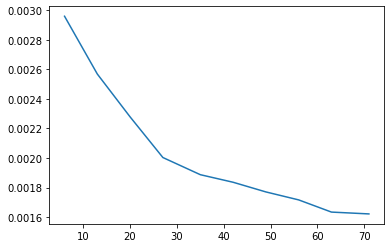

In [20]:
log['train_loss_epoch'].dropna().plot()

<AxesSubplot:>

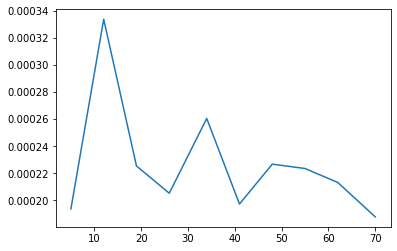

In [21]:
log['valid_loss'].dropna().plot()

In [22]:
X, y = next(iter(dl_train))

In [23]:
y_hat = model(X)

In [28]:
i=2

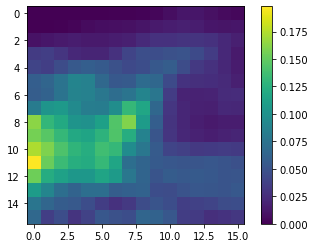

In [29]:
plt.imshow(X.numpy()[i, 0])
plt.colorbar();

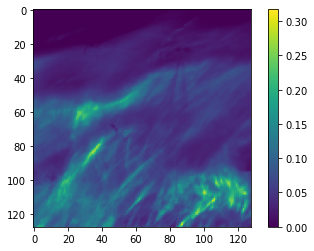

In [30]:
plt.imshow(y.numpy()[i, 0])
plt.colorbar();

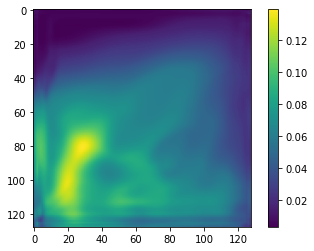

In [31]:
plt.imshow(y_hat.detach().numpy()[i, 0])
plt.colorbar();

In [62]:
trainer.logger.dd

TypeError: agg_and_log_metrics() missing 1 required positional argument: 'metrics'

In [26]:
for X, y in dl_train:
#     outputs = model(X)
#     loss = criterion(outputs, y)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    print(loss)

tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<MseLossBac

KeyboardInterrupt: 